In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/fonnescj/anaconda3/envs/jupyter_tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This dataset is from Table 6.9 of [Statistical Methods for the Analysis of Repeated Measurements](http://www.amazon.com/Statistical-Methods-Analysis-Repeated-Measurements/dp/0387953701) by Charles S. Davis, pp. 161-163 (Springer, 2002). These data are from a multicenter, randomized controlled trial of botulinum toxin type B (BotB) in patients with cervical dystonia from nine U.S. sites.

* Randomized to placebo (N=36), 5000 units of BotB (N=36), 10,000 units of BotB (N=37)
* Response variable: total score on Toronto Western Spasmodic Torticollis Rating Scale (TWSTRS), measuring severity, pain, and disability of cervical dystonia (high scores mean more impairment)
* TWSTRS measured at baseline (week 0) and weeks 2, 4, 8, 12, 16 after treatment began

## Data Import and Processing with Pandas

In [2]:
cdystonia = pd.read_csv("cdystonia.csv", index_col=None)
cdystonia.head()

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39


This dataset includes repeated measurements of the same individuals (longitudinal data). Its possible to present such information in (at least) two ways: showing each repeated measurement in their own row, or in multiple columns representing multiple measurements.


## Pivoting

The `pivot` method allows a DataFrame to be transformed easily between long and wide formats in the same way as a pivot table is created in a spreadsheet. It takes three arguments: `index`, `columns` and `values`, corresponding to the DataFrame index (the row headers), columns and cell values, respectively.

For example, we may want the `twstrs` variable (the response variable) in wide format according to patient, as we saw with the unstacking method above:

In [3]:
twstrs_wide = cdystonia.pivot(index='patient', columns='obs', values='twstrs')
twstrs_wide.head()

obs,1,2,3,4,5,6
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


In [4]:
cdystonia_wide = (cdystonia[['patient','site','id','treat','age','sex']]
                  .drop_duplicates()
                  .merge(twstrs_wide, right_index=True, left_on='patient', how='inner')
                  .head())
cdystonia_wide

,patient,site,id,treat,age,sex,1,2,3,4,5,6
0,1,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
6,2,1,2,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
12,3,1,3,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
18,4,1,4,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
22,5,1,5,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


A slightly cleaner way of doing this is to set the patient-level information as an index before unstacking:

In [5]:
(cdystonia.set_index(['patient','site','id','treat','age','sex','week'])['twstrs']
     .unstack('week').head())

,,,,,week,0,2,4,8,12,16
patient,site,id,treat,age,sex,,,,,,
1,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
2,1,2,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
3,1,3,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
4,1,4,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
5,1,5,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


To convert our "wide" format back to long, we can use the `melt` function, appropriately parameterized. This function is useful for `DataFrame`s where one
or more columns are identifier variables (`id_vars`), with the remaining columns being measured variables (`value_vars`). The measured variables are "unpivoted" to
the row axis, leaving just two non-identifier columns, a *variable* and its corresponding *value*, which can both be renamed using optional arguments.

In [6]:
pd.melt(cdystonia_wide, id_vars=['patient','site','id','treat','age','sex'], 
        var_name='obs', value_name='twsters').head()

,patient,site,id,treat,age,sex,obs,twsters
0,1,1,1,5000U,65,F,1,32.0
1,2,1,2,10000U,70,F,1,60.0
2,3,1,3,5000U,64,F,1,44.0
3,4,1,4,Placebo,59,F,1,53.0
4,5,1,5,10000U,76,F,1,53.0


This illustrates the two formats for longitudinal data: **long** and **wide** formats. Its typically better to store data in long format because additional data can be included as additional rows in the database, while wide format requires that the entire database schema be altered by adding columns to every row as data are collected.

The preferable format for analysis depends entirely on what is planned for the data, so it is imporant to be able to move easily between them.

## Data visualization with Seaborn

Notice that this data represents time series of individual patients, comprised of follow-up measurements at 2-4 week intervals following treatment. We can use the `pointplot` function from the `seaborn` package to visualize time series data.

Where `pointplot` is particularly useful is in representing the central tendency and variance of multiple replicate measurements. Having examined individual responses to treatment, we may now want to look at the average response among treatment groups. Where there are mutluple outcomes (y variable) for each predictor (x variable), `pointplot` will plot the mean, and calculate the 95% confidence interval for the mean, using bootstrapping:

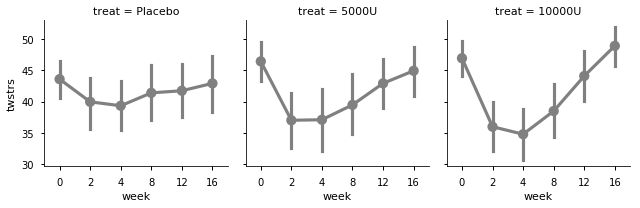

In [12]:
ordered_treat = ['Placebo', '5000U', '10000U']
g = sns.FacetGrid(cdystonia, col='treat', col_order=ordered_treat)
g.map(sns.pointplot, 'week', 'twstrs', color='0.5', order=None)

`displot` can also fit parametric data models (instead of a kde). For example, we may wish to fit the data to normal distributions. We can used the distributions included in the SciPy package; Seaborn knows how to use these distributions to generate a fit to the data.

/Users/fonnescj/anaconda3/envs/jupyter_tutorial/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


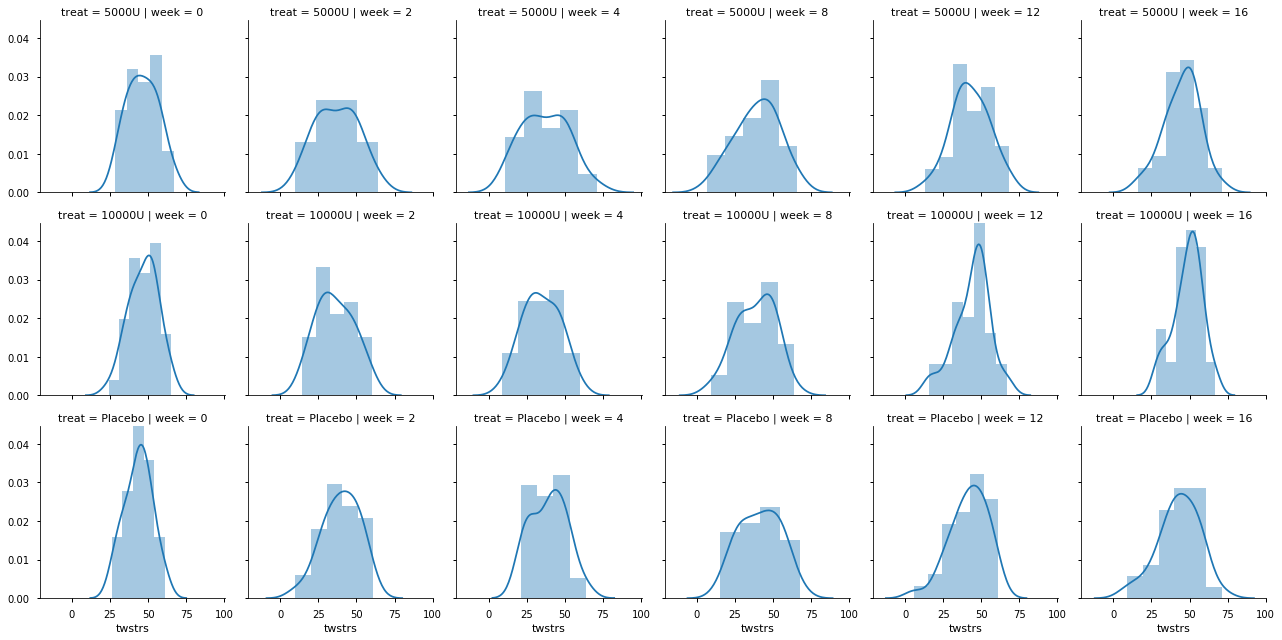

In [14]:
from scipy.stats import norm

g = sns.FacetGrid(cdystonia, row='treat', col='week')
g.map(sns.distplot, 'twstrs', kde=False, fit=norm)

## Data Analysis with PyMC3

In [13]:
treatment_ind = pd.get_dummies(cdystonia.treat)
treatment_ind.head()

,10000U,5000U,Placebo
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [14]:
female = cdystonia.sex.replace({'F':1, 'M':0})

In [26]:
analysis_subset = (cdystonia[['age', 'twstrs']].join(female)
                                    .join(treatment_ind[['10000U', '5000U']]))[cdystonia.week==4]

analysis_subset.columns = ('age', 'outcome', 'female', 'high_dose', 'low_dose')

analysis_subset.head()

,age,outcome,female,high_dose,low_dose
2,65,24,1,0,1
8,70,27,1,1,0
14,64,23,1,0,1
20,59,64,1,0,0
24,76,48,1,1,0


In [27]:
from pymc3 import Model, glm

with Model() as model:
    
    glm.GLM.from_formula('outcome ~ age + female + low_dose + high_dose', data=analysis_subset)
    

In [28]:
from pymc3 import sample

with model:
    
    trace = sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/fonnescj/anaconda3/envs/jupyter_tutorial/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, high_dose, low_dose, female, age, Intercept]
100%|██████████| 3000/3000 [00:12<00:00, 233.70it/s]


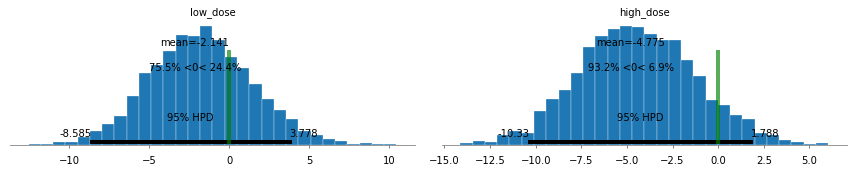

In [34]:
from pymc3 import plot_posterior

plot_posterior(trace, varnames=['low_dose', 'high_dose'], ref_val=0);

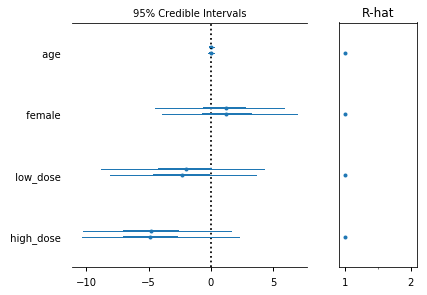

In [35]:
from pymc3 import forestplot

forestplot(trace, varnames=['age', 'female', 'low_dose', 'high_dose']);